# Standard Precipitaion Index (SPI)

In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [164]:
import logging
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.animation import FuncAnimation

import xarray as xr
import geopandas as gpd

from mergedownloader.file_downloader import FileDownloader, ConnectionType
from mergedownloader.downloader import Downloader
from mergedownloader.inpeparser import *
from mergedownloader.utils import DateProcessor, DateFrequency

In [11]:
fd = FileDownloader(INPE_SERVER, connection_type=ConnectionType.HTTP)

Using wget through HTTP on: ftp.cptec.inpe.br


In [12]:
downloader = Downloader(
    file_downloader=fd,
    parsers=InpeParsers,
    local_folder='/workspaces/reports_folder/downloads2/',
    log_level=logging.DEBUG
)

In [13]:
InpeParsers

{<InpeTypes.DAILY_RAIN: 1>: Instance of DailyParser,
 <InpeTypes.MONTHLY_ACCUM_YEARLY: 2>: Instance of MonthlyAccumYearlyParser,
 <InpeTypes.DAILY_AVERAGE: 3>: Instance of DailyAverageParser,
 <InpeTypes.MONTHLY_ACCUM: 4>: Instance of MonthlyAccumParser,
 <InpeTypes.MONTHLY_ACCUM_MANUAL: 5>: Instance of MonthlyAccumManual,
 <InpeTypes.YEARLY_ACCUM: 6>: Instance of YearAccumulatedParser,
 <InpeTypes.MONTHLY_SP1: 8>: Instance of SPI1Processor}

## Calculate SPI for 1 month timeframe 

In [14]:
# spi = downloader.get_file('2024-08-05', datatype=InpeTypes.MONTHLY_SP1)
# spi

In [15]:
# dates = DateProcessor.dates_range('2023-01-01', '2024-08-01', date_freq=DateFrequency.MONTHLY)

# for date in dates:
#     print(f'Processing {date}')
#     spi = downloader.get_file(date, datatype=InpeTypes.MONTHLY_SP1)
#     print(spi)

In [18]:
spi = downloader.open_file('2023-03-05', datatype=InpeTypes.MONTHLY_SP1)

<Axes: >

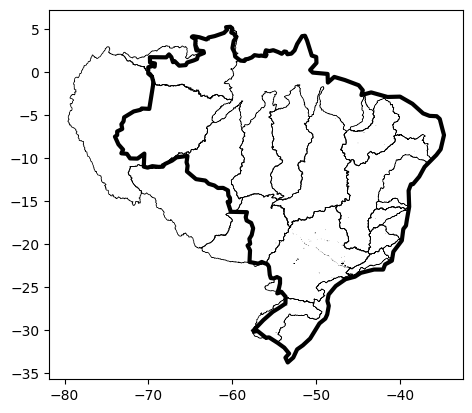

In [30]:
countries = gpd.read_file('https://d2ad6b4ur7yvpq.cloudfront.net/naturalearth-3.3.0/ne_110m_admin_0_countries.geojson')
br = countries.query("adm0_a3 == 'BRA'")
basins = gpd.read_file('/workspaces/bases/bacias de interesse SOE/bacias_interesse_ANA.shp')
ax = br.plot(facecolor='none', linewidth=3)
basins.plot(ax=ax, facecolor='none', linewidth=0.5)

(-35.7207944099458, 7.232371429045038)

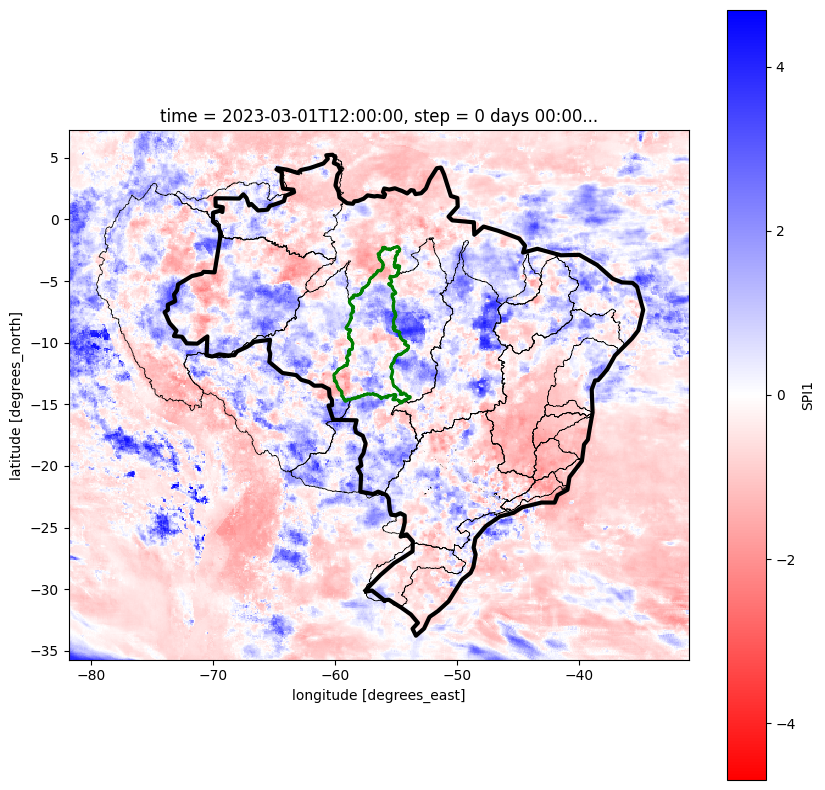

In [56]:
fig, ax = plt.subplots(figsize=(10, 10))

br.plot(ax=ax, facecolor='none', linewidth=3, zorder=1)
basins.plot(ax=ax, facecolor='none', linewidth=0.5, zorder=1)
basins.loc[[9]].plot(ax=ax, facecolor='none', linewidth=2, edgecolor='green', zorder=2)

# Get the bounds of the plot
xmin, xmax, ymin, ymax = ax.axis()

spi.plot(cmap='bwr_r', ax=ax, zorder=0)
ax.set_xlim(xmin, -31)
ax.set_ylim(ymin, ymax)


## 12 months animation

In [65]:
spi_cube = downloader.create_cube('2023-08', '2024-08', datatype=InpeTypes.MONTHLY_SP1)

In [93]:
spi_brasil = spi_cube.rio.clip(br['geometry'])

In [97]:
tapajos = basins.loc[[9]]
spi_tapajos = spi_cube.rio.clip(tapajos['geometry'])

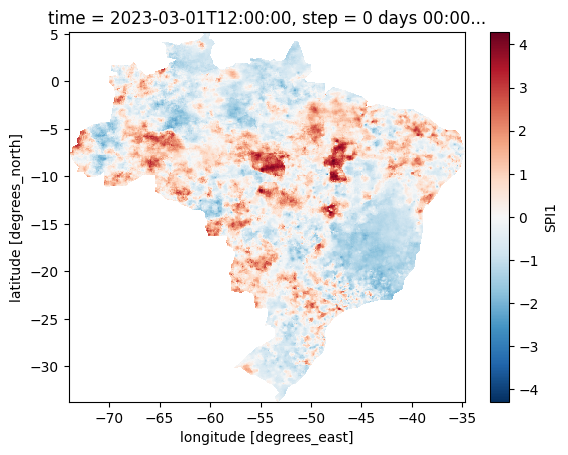

In [68]:
spi_brasil.isel(time=0).plot()

In [98]:
spi_series = spi_tapajos.mean(dim=['latitude', 'longitude']).to_series()

Text(0.5, 1.0, 'Índice SPI (1 mês) - Brasil')

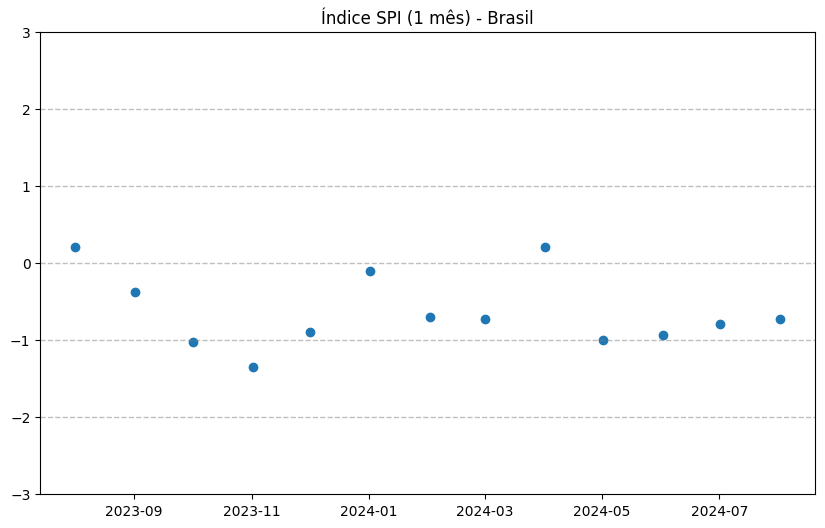

In [99]:
fig, ax = plt.subplots(figsize=(10, 6))

# draw thin and dashed fixed horizontal lines at y=0, y=-1 and y=1
for y in [-2, -1, 0, 1, 2]:
    ax.axhline(y, color='grey', alpha=0.5, linewidth=1, linestyle='dashed')

ax.scatter(spi_series.index, spi_series)

ax.set_ylim(-3, 3)
ax.set_title('Índice SPI (1 mês) - Brasil')

In [155]:
def plot_spi1_map(ax: plt.Axes, itime: int, cube: xr.DataArray, shp: gpd.GeoDataFrame, vmax: float, vmin: float, add_colorbar: bool):
    shp.plot(ax=ax, facecolor='none', linewidth=3)
    xmin, xmax, ymin, ymax = ax.axis()

    cube.isel(time=itime).plot.imshow(ax=ax, cmap='bwr_r', vmax=vmax, vmin=vmin, add_colorbar=add_colorbar)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    date = DateProcessor.pretty_date(cube.time.values[itime].astype('str')[:10], "%Y-%m")
    ax.set_title(f'Índice SPI (1 mês)\n{date}')
    
def plot_spi1_chart(ax: plt.Axes, itime: int, cube: xr.DataArray, vmax: float, vmin: float):
    cube_series = cube.mean(dim=['latitude', 'longitude']).to_series()

    ax.scatter(cube_series.index, cube_series)

    ax.set_ylim(-3, 3)
    ax.set_title('Índice SPI (1 mês) - Brasil')

    for y in [-2, -1, 0, 1, 2]:
        ax.axhline(y, color='grey', alpha=0.5, linewidth=1, linestyle='dashed')   

    ax.axvline(cube_series.index[itime], color='red', alpha=0.2) 
    ax.scatter(cube_series.index[itime], cube_series.iloc[itime], color='red', s=55)    

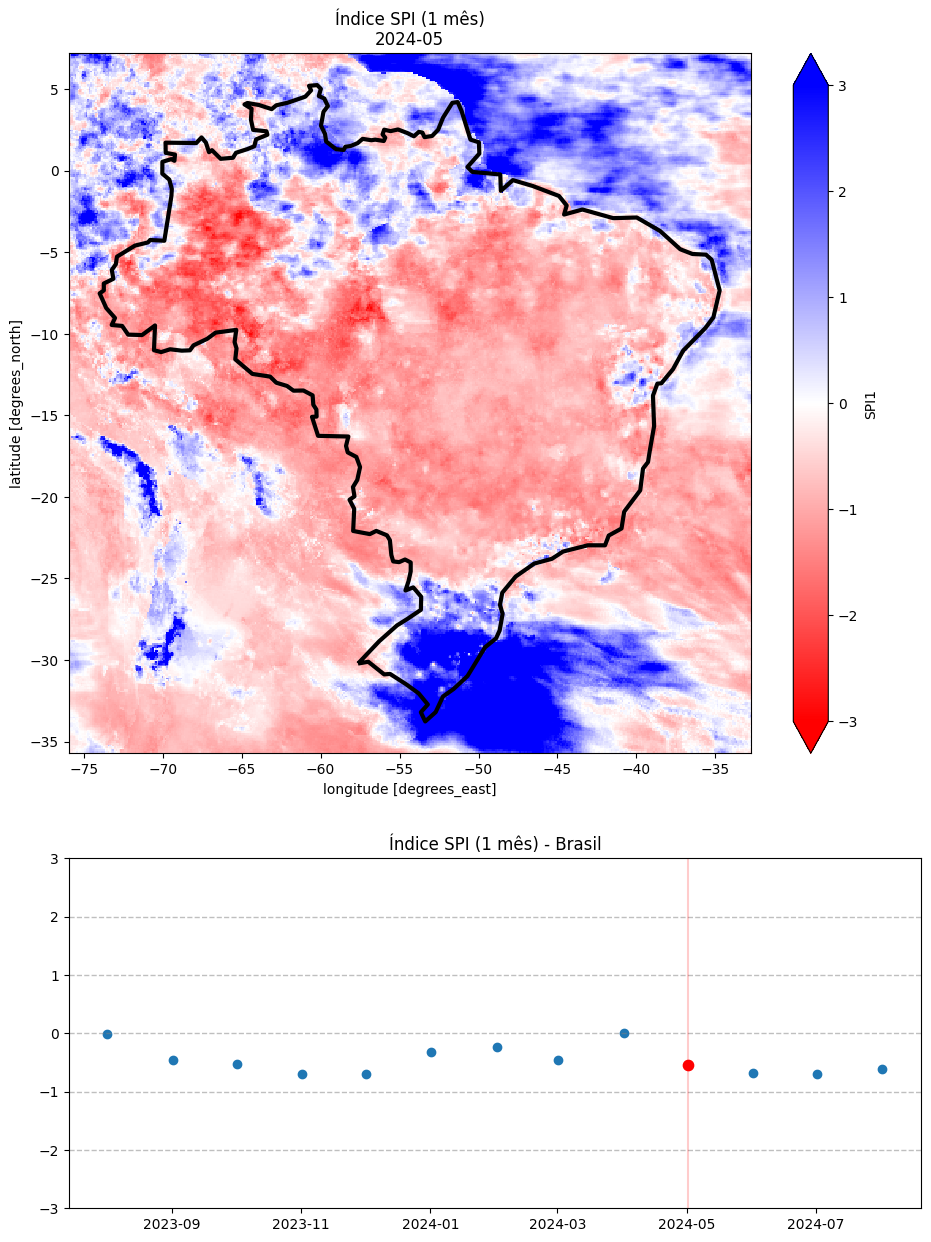

In [156]:
# create a figure with a 2x1 subplot, but the plots have distinct heights
fig = plt.figure(figsize=(11, 15))
gs = GridSpec(2, 1, figure=fig, height_ratios=[2, 1])
axs = [fig.add_subplot(gs[0]), fig.add_subplot(gs[1])]

itime = 9
plot_spi1_map(
    ax=axs[0],
    itime=itime,
    cube=spi_cube,
    shp=br,
    vmax=3,
    vmin=-3,
    add_colorbar=True
)

plot_spi1_chart(
    ax=axs[1],
    itime=itime,
    cube=spi_brasil,
    vmax=3,
    vmin=-3
)

## Animation Loop

In [163]:
def update(frame):
    axs[0].clear()
    plot_spi1_map(axs[0], frame, spi_cube, br, 3, -3, False)

    axs[1].clear()
    plot_spi1_chart(axs[1], frame, spi_brasil, 3, -3)

    return axs[0].get_images()



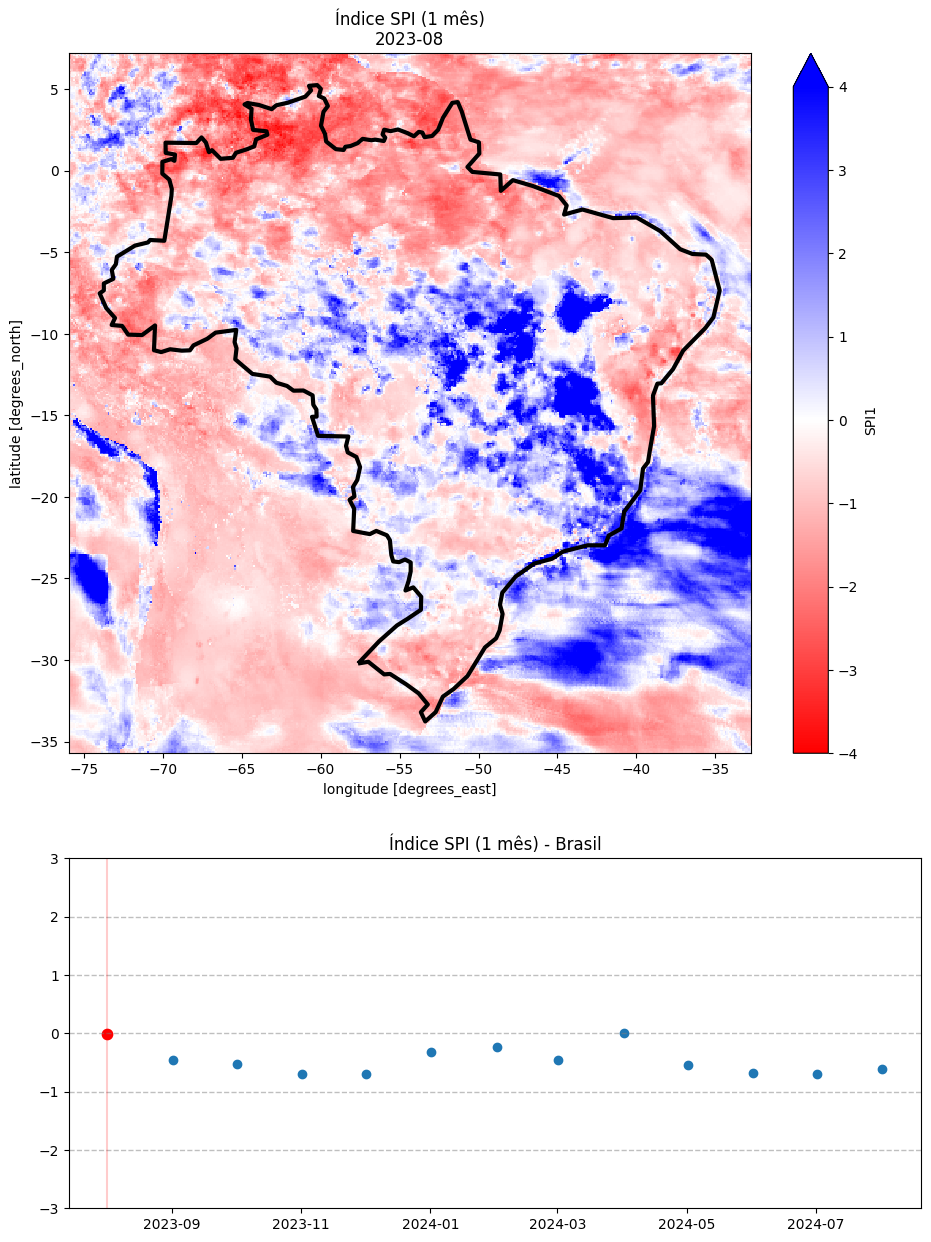

In [165]:
vmin=-4
vmax=4

# create a figure with a 2x1 subplot, but the plots have distinct heights
fig = plt.figure(figsize=(11, 15))
gs = GridSpec(2, 1, figure=fig, height_ratios=[2, 1])
axs = [fig.add_subplot(gs[0]), fig.add_subplot(gs[1])]

# Draw first map
plot_spi1_map(axs[0], 0, spi_cube, br, vmax, vmin, True)
plot_spi1_chart(axs[1], 0, spi_brasil, vmax, vmin)

anim = FuncAnimation(fig, update, frames=len(spi_cube.time), blit=True)

In [166]:
anim.save('monthly_spi1_brasil.gif', writer='pillow', fps=1)

<Figure size 640x480 with 0 Axes>

In [60]:
spi_basin = spi.rio.clip(tapajos['geometry'])

In [63]:
spi_basin.mean()

<xarray.DataArray 'SPI1' ()>
array(0.27019575)
Coordinates:
    step         timedelta64[ns] ...
    surface      float64 ...
    spatial_ref  int64 0

In [64]:
spi.mean()

<xarray.DataArray 'SPI1' ()>
array(-0.08096095)
Coordinates:
    step         timedelta64[ns] ...
    surface      float64 ...
    spatial_ref  int64 ...

In [10]:
spi = downloader.open_file('2024-08-05', datatype=InpeTypes.MONTHLY_SP1)

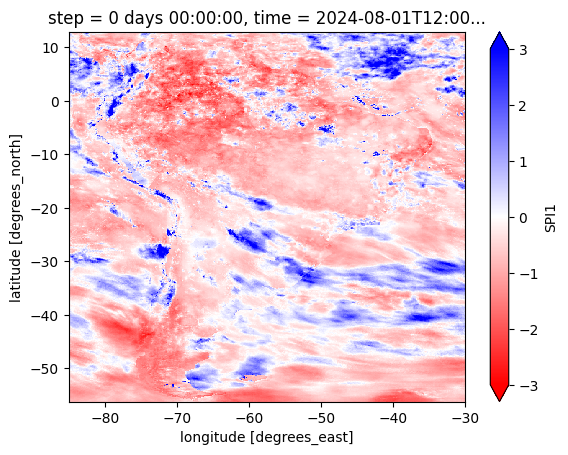

In [79]:
spi.plot(cmap='bwr_r', vmin=-3, vmax=3)

In [24]:
start_year = 2001
end_year = 2023
month = 8

dates = []
for year in range(start_year, end_year + 1):
    date = f'{year}-{month:02}-01'
    dates.append(date)


In [7]:
len(dates)

23

In [8]:
cube = downloader.create_cube_dates(dates, datatype=InpeTypes.MONTHLY_ACCUM_YEARLY)

/usr/local/lib/python3.10/dist-packages/ecmwflibs/__init__.py:81: UserWarning: libglib-2.0.so.0: cannot open shared object file: No such file or directory
  warnings.warn(str(e))


In [9]:
cube

<xarray.DataArray 'pacum' (time: 23, latitude: 691, longitude: 551)>
array([[[118.25  , 121.375 , 121.    , ...,  58.25  ,  52.25  ,
          48.25  ],
        [122.625 , 114.375 , 114.    , ...,  70.125 ,  68.875 ,
          72.125 ],
        [112.875 , 115.25  , 119.625 , ...,  60.625 ,  63.375 ,
          64.25  ],
        ...,
        [363.5   , 323.125 , 374.625 , ..., 218.375 , 203.375 ,
         239.5   ],
        [391.    , 404.875 , 391.5   , ..., 195.875 , 169.5   ,
         185.5   ],
        [485.625 , 439.25  , 389.875 , ..., 170.5   , 160.625 ,
         170.625 ]],

       [[139.125 , 140.9375, 143.4375, ...,   2.5625,   3.4375,
           4.4375],
        [132.3125, 136.25  , 139.3125, ...,   3.0625,   4.0625,
           4.5625],
        [118.5625, 126.1875, 124.125 , ...,   2.625 ,   3.5   ,
           4.6875],
...
        [168.625 , 218.5625, 228.3125, ..., 148.625 , 163.75  ,
         172.25  ],
        [198.75  , 224.9375, 235.9375, ..., 138.25  , 152.5   ,
         153.375 ],
        [169.25  , 217.625 , 231.3125, ..., 113.75  , 116.    ,
         116.375 ]],

       [[ 80.    ,  84.375 ,  83.375 , ..., 147.625 , 148.5   ,
         143.375 ],
        [ 87.625 ,  91.    ,  94.625 , ..., 151.    , 147.125 ,
         138.375 ],
        [ 93.75  ,  96.5   ,  99.125 , ..., 141.    , 139.    ,
         131.5   ],
        ...,
        [160.    , 146.75  , 167.25  , ..., 112.25  , 119.625 ,
         144.125 ],
        [155.    , 147.    , 157.875 , ...,  98.    , 117.25  ,
         128.375 ],
        [153.75  , 147.75  , 148.5   , ...,  89.875 , 106.75  ,
         114.375 ]]])
Coordinates:
  * longitude    (longitude) float64 -85.05 -84.95 -84.85 ... -30.15 -30.05
  * latitude     (latitude) float64 -56.15 -56.05 -55.95 ... 12.65 12.75 12.85
  * time         (time) datetime64[ns] 2001-08-01T12:00:00 ... 2023-08-01T12:...
    spatial_ref  int64 0

In [10]:
std = cube.std(dim="time")
avg = cube.mean(dim="time")

In [11]:
rain = downloader.open_file('2024-08-05', datatype=InpeTypes.MONTHLY_ACCUM_MANUAL)

In [17]:
rain

<xarray.DataArray 'pacum' (time: 1, latitude: 691, longitude: 551)>
array([[[ 96.0625,  95.5   ,  93.3125, ...,  10.    ,  11.3125,
           9.    ],
        [ 93.    ,  87.9375,  84.8125, ...,   7.25  ,   6.4375,
           9.75  ],
        [ 90.5625,  89.125 ,  84.875 , ...,   8.4375,   9.875 ,
           9.9375],
        ...,
        [247.375 , 268.125 , 254.125 , ...,  91.9375,  97.1875,
          76.9375],
        [239.1875, 234.125 , 229.6875, ..., 106.875 , 109.1875,
          98.    ],
        [225.1875, 241.0625, 232.0625, ..., 102.5   , 107.3125,
          94.8125]]], dtype=float32)
Coordinates:
  * longitude    (longitude) float64 -85.05 -84.95 -84.85 ... -30.15 -30.05
  * latitude     (latitude) float64 -56.15 -56.05 -55.95 ... 12.65 12.75 12.85
    step         timedelta64[ns] 00:00:00
    surface      float64 2.55e+03
  * time         (time) datetime64[ns] 2024-08-01T12:00:00
    spatial_ref  int64 0

In [12]:
rain = rain.rio.reproject_match(std)

In [13]:
rain = rain.rename({"x": "longitude", "y": "latitude"})


In [14]:
anomaly = rain - avg

In [15]:
z = anomaly / std

In [16]:
z

<xarray.DataArray 'pacum' (time: 1, latitude: 691, longitude: 551)>
array([[[-0.75213814, -0.75960002, -0.77835419, ..., -0.79911509,
         -0.75702654, -0.8304678 ],
        [-0.77060235, -0.8182685 , -0.86143326, ..., -0.84555553,
         -0.88892135, -0.84642459],
        [-0.77523228, -0.79708097, -0.83994791, ..., -0.84902176,
         -0.83216075, -0.82173227],
        ...,
        [ 0.35888666,  0.70510113,  0.42443041, ..., -0.61423522,
         -0.57815612, -0.79095297],
        [ 0.12794625, -0.07093542, -0.28851357, ..., -0.39885572,
         -0.42451882, -0.5297368 ],
        [-0.17228148, -0.08968451, -0.24730061, ..., -0.34004009,
         -0.30963452, -0.43725632]]])
Coordinates:
  * longitude    (longitude) float64 -85.05 -84.95 -84.85 ... -30.15 -30.05
  * latitude     (latitude) float64 -56.15 -56.05 -55.95 ... 12.65 12.75 12.85
    step         timedelta64[ns] 00:00:00
    surface      float64 2.55e+03
  * time         (time) datetime64[ns] 2024-08-01T12:00:00
    spatial_ref  int64 0

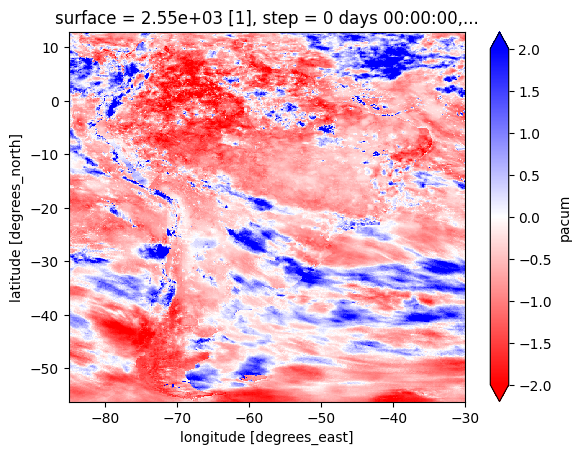

In [36]:
z.plot(cmap='bwr_r', vmin=-2, vmax=2)

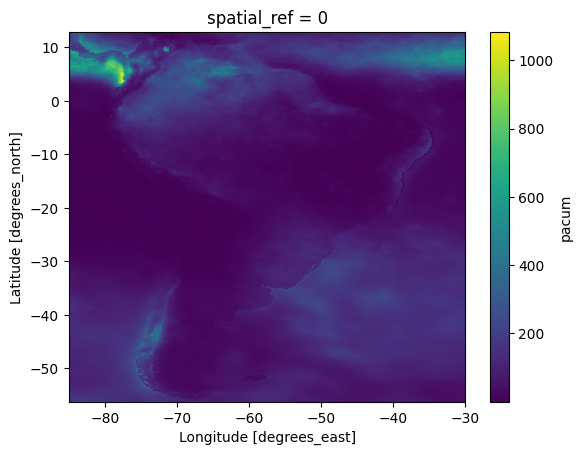

In [22]:
cube.mean(dim="time").plot()